<a href="https://colab.research.google.com/github/BalintVargaBME/Deep-Learning-a-gyarkolatban---BitMesterek/blob/main/BitMesterek_Optiver_Trading_at_the_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#VB
# Import libraries
import pandas as pd
import os
import zipfile
import numpy as np
import random
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [ ]:
#VB
# Mount drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#VB
# Navigate to working directory
# Change to your own Drive directory after MyDrive/

%cd /content/drive/MyDrive/Deep Learning a gyakorlatban/Nagy házi/

# Telling Kaggle where to find the API key, needed for dowloading dataset, change to your own directory after MyDrive/
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Deep Learning a gyakorlatban/Nagy házi"

[Errno 2] No such file or directory: '/content/drive/MyDrive/Deep Learning a gyakorlatban/Nagy házi/'
/content


In [ ]:
#VB
# Commented out so Colab won't download each time when all cells are run

# Download data from Kaggle
# !kaggle competitions download -c optiver-trading-at-the-close

In [ ]:
#VB

# Commented out so Colab won't download each time when all cells are run
# Unzip, then delete file
'''
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)
'''
# List files in working directory
%ls

'BitMesterek - Optiver: Trading at the close.ipynb'   optiver2023/
 example_test_files/                                  public_timeseries_testing_util.py
 kaggle.json                                          train.csv


In [ ]:
#VB
import_data = pd.read_csv ('train.csv')
import_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


Number of datapoints:

200 stocks
481 days
55 steps each day

So number of datapoints should be 200 * 481 * 55  (stocks * days * steps) = 5291000

In [ ]:
#VB
import_data.shape

(5237980, 17)

We can see that 53020 datapoints are missing

In [ ]:
#VB
data_frame = import_data

# Group the data by 'date_id' and count the unique 'stock_id' values for each day
stock_count_per_day = data_frame.groupby('date_id')['stock_id'].nunique()

# Expected number of stocks each day
expected_stock_count = 200

# Number of missing stocks each day
missing_stock_count = expected_stock_count - stock_count_per_day

# Total missing stocks througouth the 200 days
total_missing_stocks = missing_stock_count.sum()

# Days and number of missing stocks
print("Date and number of missing stocks:")
print(missing_stock_count)

# Total number of missing stocks
print("Total number of missing stocks:", total_missing_stocks)


Date and number of missing stocks:
date_id
0      9
1      9
2      9
3      9
4      8
      ..
476    0
477    0
478    0
479    0
480    0
Name: stock_id, Length: 481, dtype: int64
Total number of missing stocks: 964


As we can see throughout the 481 days a total of 964 stocks are missing entirely. 964 * 55 = 53020,  so this means that missing data is found. This also means that fortunately that the stock data that we do have doesn't have any missing values.

In [ ]:
#VB
# Function to plot the time series of a stock on a day
def stock_plotter(data_frame, cols, stock_id, date_id):

  # Filtering data_frame where the stock_id and date_id match with our inputs
  data_frame = data_frame.query(f'stock_id == {stock_id} & date_id == {date_id}')

  # We want all rows of the seconds_in_bucket and input columns
  data_frame = data_frame.loc[:, ['seconds_in_bucket'] + cols]

  # Set seconds_in_bucket as the index for the data_frame
  data_frame = data_frame.set_index('seconds_in_bucket')

  # Plot time series
  data_frame = data_frame.plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)

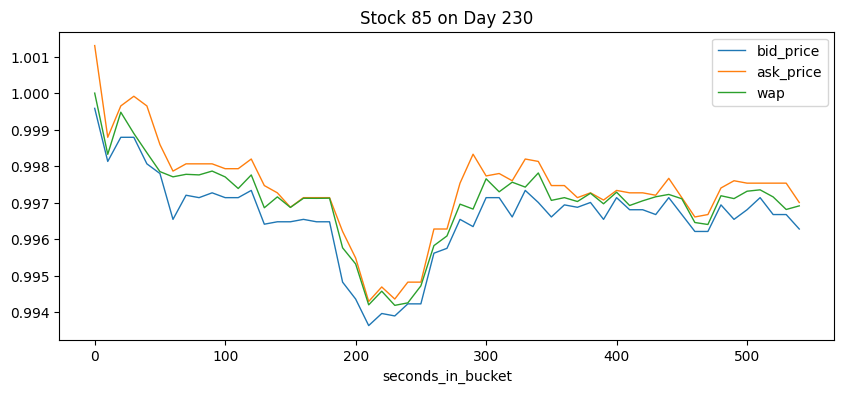

In [ ]:
#VB
# Generate random numbers to print random stocks on random days, not excluding the missing ones (will have to fix in future)
stock_no = random.randint(0,200)
day_no = random.randint(0,481)

# Plot
stock_plotter(
  data_frame=import_data,
  cols=['bid_price','ask_price', 'wap'],
  stock_id=stock_no,
  date_id=day_no)



In [ ]:
#VB

# Dropping NaN values because they cause errors in calculatin MAE
data_frame = data_frame.dropna(subset=['target'])

# Splitting data, dropping row_id becaues it's not necesseary, and it's 'object' type causing error with pandas
X = data_frame.drop(['target', 'row_id'], axis=1)
y = data_frame[['target']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,)

In [ ]:
#VB
# Storing hyperparameters and MAE score, will have better system for it in future
model_params = []
model_mae = []

In [ ]:
#VB
# Using LGBM framework for training model
from lightgbm import LGBMRegressor
params={'n_estimators': 300,
        'learning_rate': 0.09,
        'max_depth': 8,
        'num_leaves': 25,
        }

model=LGBMRegressor(**params, random_state=123, device='cpu')
model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3316
[LightGBM] [Info] Number of data points in the train set: 3928419, number of used features: 15
[LightGBM] [Info] Start training from score -0.048789


LGBMRegressor(device='cpu', learning_rate=0.09, max_depth=8, n_estimators=300,
              num_leaves=25, random_state=123)

In [ ]:
#VB
# Get predictions of test set
pred_LGB=model.predict(X_test)

# Calculate the mean absolute error of the predictions and target
mean_ae = mean_absolute_error(y_test,pred_LGB)
print("MAE score of model =", mean_ae)

# Store hyperparameters and score
model_params.append(model)
model_mae.append(mean_ae)

MAE score of Support Vector Regression Model = 6.289176747758884


In [ ]:
#VB
print(model_params, model_mae)

[LGBMRegressor(device='cpu', learning_rate=0.09, max_depth=8, n_estimators=300,
              num_leaves=25, random_state=123)] [6.289176747758884]
